# Classifying Cats and Dogs using CNN and Transfer Learning
> We'll build a model to try and identify whether images contain a dog or a cat.

In the world of artificial intelligence, CNNs are the "eyes" of the computer, while Transfer Learning is the shortcut we use to make those eyes smarter without starting from scratch.

**CNN**

A Convolutional Neural Network (CNN) is a type of deep learning model specifically designed to process pixel data. Unlike traditional neural networks that see an image as just a flat list of numbers, a CNN understands spatial relationships—it "looks" for patterns like edges, textures, and shapes.


How it works (The Three Core Layers):

- Convolutional Layers: These act like filters. They slide across the image to detect features. Early layers might find simple lines, while deeper layers detect complex objects like "eyes" or "wheels."

- Pooling Layers: These simplify the data. They reduce the size of the image representation while keeping the most important information (like a summary), which helps the model run faster.

- Fully Connected (Dense) Layers: After the features are extracted, these layers act like a traditional classifier to decide what the image actually is (e.g., "This is a dog").

**Transfer Learning**

Transfer Learning is a technique where you take a model that has already been trained on a massive dataset (like ImageNet, which has millions of images) and repurpose it for your own specific, smaller task.

Why use it?

- Small Datasets: Training a CNN from scratch requires thousands of images. With transfer learning, you can get high accuracy with just a few hundred.

- Speed: Instead of training for days on expensive hardware, you can "fine-tune" a pre-trained model in minutes or hours.

- Proven Knowledge: You are starting with a model that already knows what "edges," "curves," and "shapes" look like. You only need to teach it the specific details of your new task.

In [ ]:
# Comment out if not required
%pip install -r requirements.txt

Tensorflow will try to use cuda drivers for NVIDIA GPU , but if does not find a GPU (or compatible GPU), then it will automatically default to CPU mode

In [ ]:
# import required libraries
import os
import zipfile
import random
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

---
## Explore the Data
Download the dataset using the code block below. The data also needs to be split into a training and testing set.  
The code block below downloads the full Cats-v-Dogs dataset and stores it as `cats-and-dogs.zip`. It then unzips it to `/tmp`, which will create a `tmp/PetImages` directory containing subdirectories called `Cat` and `Dog`.

In [ ]:
# Download the updated Cats vs Dogs dataset

# Note that ZIP file size is 786.67MB 

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

# Extract the zip file
local_zip = '/tmp/cats-and-dogs.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/tmp')


In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


Use `os.mkdir` to create directories. We need a directory for `cats-v-dogs`, and subdirectories for `training` and `testing`. These in turn will need subdirectories for `cats` and `dogs`.

In [5]:
to_create = [
             '/tmp/cats-v-dogs',
             '/tmp/cats-v-dogs/training',
             '/tmp/cats-v-dogs/testing',
             '/tmp/cats-v-dogs/training/cats',
             '/tmp/cats-v-dogs/training/dogs',
             '/tmp/cats-v-dogs/testing/cats',
             '/tmp/cats-v-dogs/testing/dogs'
            ]

for directory in to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except OSError:
        pass

/tmp/cats-v-dogs created
/tmp/cats-v-dogs/training created
/tmp/cats-v-dogs/testing created
/tmp/cats-v-dogs/training/cats created
/tmp/cats-v-dogs/training/dogs created
/tmp/cats-v-dogs/testing/cats created
/tmp/cats-v-dogs/testing/dogs created


Python function called `split_data` which takes a `SOURCE` directory containing the files, `TRAINING` and `TESTING` directories that a portion of the files will be copied to, and a `SPLIT_SIZE` to determine the portion of the split.  

The files should also be randomized, so that the training set is a random X% of the files, and the test set is the reamining files.  

Also, all images should be checked, and if they have a zero files length, they will not be copied over.

`os.listdir(DIRECTORY)` gives you a listing of the contents of that directory.  

`os.path.getsize(PATH)` gives you the size of the file.  

`copyfile(source, destination)` copies a file from source to destination.  

`random.sample(list, len(list))` shuffles a list.

In [ ]:

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []

    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))

    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)

    shuffled = random.sample(all_files, n_files)

    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]

    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)

    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring
11702.jpg is zero length, so ignoring


In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))


11250
11250
1250
1250


There are 11,250 images each in the training set of the cats and dogs directories.  
There are 1,250 images each in the test set of the cats and dogs directories.

Let's see what the file names look like in the cats and dogs training directories. We will see that there are no labels in the dataset.

In [8]:
train_cat_fnames = os.listdir('/tmp/cats-v-dogs/training/cats/')
train_dog_fnames = os.listdir('/tmp/cats-v-dogs/training/dogs/')

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['9515.jpg', '10773.jpg', '11343.jpg', '10800.jpg', '7408.jpg', '7156.jpg', '5514.jpg', '692.jpg', '3902.jpg', '8140.jpg']
['9515.jpg', '10773.jpg', '11343.jpg', '10800.jpg', '7408.jpg', '1223.jpg', '7156.jpg', '5514.jpg', '692.jpg', '3902.jpg']


Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. 

- Display a batch of 8 cat and 8 dog pictures. We can rerun the cell to see a fresh batch each time.

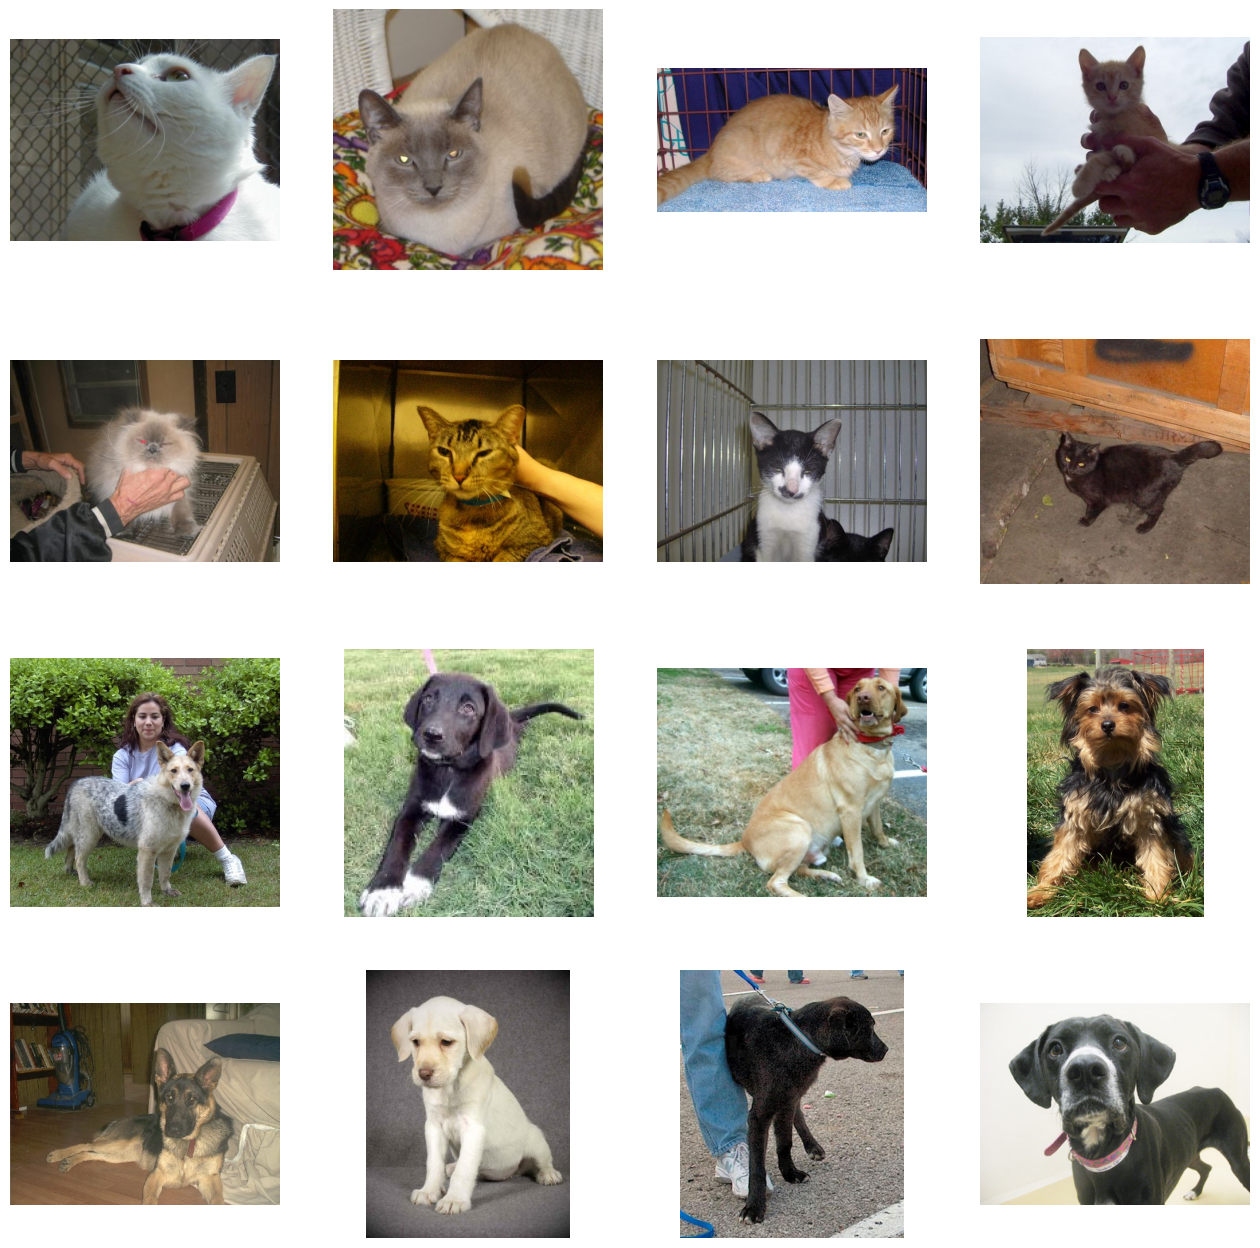

In [12]:
%matplotlib inline

# parameters for our graph
nrows = 4
ncols = 4

# index for iterating over images
pic_index = 0

# set up matplotlib fig and size it to fit 4X4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join('/tmp/cats-v-dogs/training/cats/', fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join('/tmp/cats-v-dogs/training/dogs/', fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

---
## Building a model
Define a Sequential layer and add some convolutional layers. The input shape parameter will be 150 X 150 for the size and 3 (bytes) for the color depth.  
Then add a few convolutional and pooling layers, and flatten the final result to feed into the densely connected layers.

Next, configure the specifications for model training. Train our model with the binary_crossentropy loss because it's a binary classification problem and final activation is a sigmoid, so that the output of network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0). 

Use the rmsprop optimizer with a learning rate of 0.001. During training, monitor the classification accuracy.

Note: If your system does have GPU,  then CUDA error after executing below code is not fatal — your model will run on CPU.

In [13]:
# Define a kKeras model to classify cats-v-dogs
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(150, 150, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/workspaces/Convolutional-Neural-Networks/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-15 11:31:35.029056: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


The `model.summary()` method prints a summary of the neural network.

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,518,401 (13.42 MB)

 Trainable params: 3,518,401 (13.42 MB)

 Non-trainable params: 0 (0.00 B)

The *output shape* column shows how the size of our feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

---
## Data Preprocessing

Let's set up the data generators that will read the pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. 

One generator for the training images and one for the validation images. The generators will yield batches of 20 images of size 150 X 150 and their labels (binary).

Preprocess images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).  

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows us to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. 

These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [15]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(
    rescale=1 / 255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=64,
    class_mode='binary',
    target_size=(150, 150)
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Considering time and GPU constraints, set the epochs to 25

In [ ]:
#If your system doesnt have GPU, below code will take 30min to run

history = model.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

There are four values per epoch - *loss*, *accuracy*, *validation loss* and *validation accuracy*.  

The *loss* and *accuracy* are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. The *accuracy* is the portion of correct guesses. 

The *validation accuracy* is the measurement with the data that has not been used in training. As expected, this would be a bit lower.

---
## Evaluating accuracy and loss for the model
Let's plot the training/validation accuracy and loss, during training.

Text(0.5, 1.0, 'Training and validation loss')

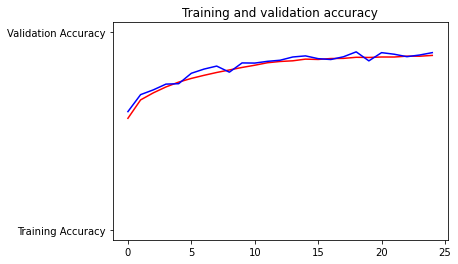

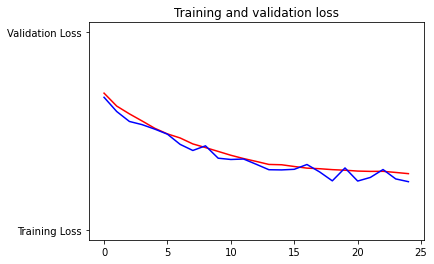

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

The graphs suggest that the validation accuracy is seen rising synchronously with the training accuracy. The validation loss is decreasing synchronously with the training accuracy.  
However, the validation accuracy and validation loss lines are wavy and are not smooth like the training lines.  
Let's see how the model performs after applying transfer learning.

---
## Transfer Learning
In Transfer Learning, we take an existing model that's trained on far more data, and use the features that that model learned.  
We'll be using the keras `layers` API, to pick at the layers, and to understand which ones we want to use, and which ones we want to retrain. A copy of the pretrained weights for the inception neural network is saved at the below URL. Keras has the model definition built-in. It's the parameters that can then get loaded into the skeleton of the model, to turn it back into a trained model. So now if we want to use Inception, it's fortunate that keras has the model definition built in.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

--2020-08-20 15:45:07--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   199MB/s    in 0.4s    

2020-08-20 15:45:08 (199 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



The inception V3 has a fully-connected layer at the top. So by setting `include_top=false`, we're specifying that we want to ignore this and get straight to the convolutions. Now that we have our pretrained model instantiated, we can iterate through its layers and lock them, saying that they're not going to be trainable with this code.

In [ ]:
#collapse-output
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable=False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Looking at the summary, the bottom layers have concoluted to 3 X 3. But I want to use something with a little more information, so I'll move up the model description to find `mixed7`, which is the output of a lot of convolutions that are 7 X 7. We can experiment with other layers as well.  
We'll define our new model, taking the output from the inception model's mixed7 layer, which we call `last_output`.

In [ ]:
# flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# add a fully connected layer with 1,024 hidden units and ReLu activation
x = layers.Dense(1024, activation='relu')(x)

# add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer= RMSprop(lr=0.0001),
              loss= 'binary_crossentropy',
              metrics= ['accuracy'])

In [ ]:
#collapse-output
history = model.fit(train_generator,
                    epochs=25,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/25
148/352 [===========>..................] - ETA: 1:54 - loss: 0.2809 - accuracy: 0.8917

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

352/352 [==============================] - 222s 631ms/step - loss: 0.2235 - accuracy: 0.9106 - val_loss: 0.1468 - val_accuracy: 0.9388
Epoch 2/25
352/352 [==============================] - 220s 625ms/step - loss: 0.1557 - accuracy: 0.9374 - val_loss: 0.1307 - val_accuracy: 0.9440
Epoch 3/25
352/352 [==============================] - 220s 624ms/step - loss: 0.1486 - accuracy: 0.9416 - val_loss: 0.1297 - val_accuracy: 0.9440
Epoch 4/25
352/352 [==============================] - 219s 622ms/step - loss: 0.1422 - accuracy: 0.9454 - val_loss: 0.1672 - val_accuracy: 0.9364
Epoch 5/25
352/352 [==============================] - 219s 621ms/step - loss: 0.1366 - accuracy: 0.9480 - val_loss: 0.1397 - val_accuracy: 0.9556
Epoch 6/25
352/352 [==============================] - 219s 621ms/step - loss: 0.1290 - accuracy: 0.9520 - val_loss: 0.1330 - val_accuracy: 0.9476
Epoch 7/25
352/352 [==============================] - 219s 621ms/step - loss: 0.1320 - accuracy: 0.9500 - val_loss: 0.1185 - val_accura

After 25 epochs, the *training loss* = 0.1 and *training accuracy* = 0.9, while the *validation loss* = 0.11 and *validation accuracy* = 0.95.  
The model has performed much better after applying transfer learning as compared to the CNN we used earlier.


---
## Evaluating accuracy and loss for the model
Let's plot the training/validation accuracy and loss, during training.

Text(0.5, 1.0, 'Training and validation loss')

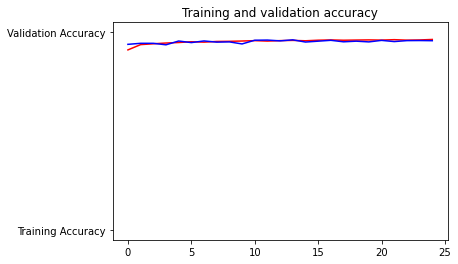

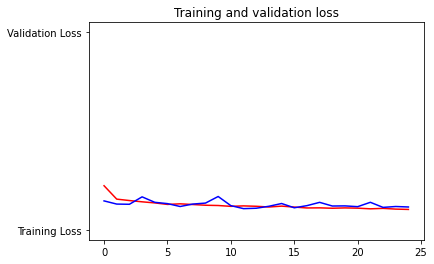

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

Here we can see that the validation loss and accuracy lines are much smoother for this model as compared to the earlier one. The loss values are lower, while the accuracy values are higher.  

Hence, we can conclude that the model that uses transfer learning classifies cats and dogs much better than the CNN.

---
